# Point Cloud Aggregation Based on GNSS-INS Data and Moving Object Filtering

**Dataset:** nuScenes v1.0-mini  
**Sensors:** LiDAR, GNSS-INS, Cameras  
**Author:** Pravin  Oli  
**Neptune Code:** XUUSY9  

This notebook implements:
1. GNSS-INS based point cloud aggregation
2. Moving object filtering without annotations
3. Point cloud colorization using camera images


# 1. Imports & Environment Setup

In [17]:
import os
import numpy as np
import cv2
import yaml
from nuscenes.nuscenes import NuScenes
from pyquaternion import Quaternion
import open3d as o3d
from tqdm import tqdm


# 2. Configuration

In [18]:
CONFIG = {
    # Point directly to the folder containing the JSON files
    "dataset_root": "../datasets/v1.0-mini",  
    "version": "v1.0-mini",
    "lidar_sensor": "LIDAR_TOP",
    "camera_sensors": [
        "CAM_FRONT", "CAM_FRONT_LEFT", "CAM_FRONT_RIGHT",
        "CAM_BACK", "CAM_BACK_LEFT", "CAM_BACK_RIGHT"
    ],
    "voxel_size": 0.2,
    "min_observations": 3
}

print(os.listdir(CONFIG["dataset_root"]))

['LICENSE', 'v1.0-mini', 'maps', 'sweeps', '.v1.0-mini.txt', 'samples']


# 3. Load nuScenes Dataset

In [19]:
nusc = NuScenes(
    version=CONFIG["version"],
    dataroot=CONFIG["dataset_root"],
    verbose=True
)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.587 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


# 4. Helper Functions (Transforms)

In [20]:
def pose_to_matrix(translation, rotation):
    T = np.eye(4)
    T[:3, :3] = Quaternion(rotation).rotation_matrix
    T[:3, 3] = translation
    return T

# 5. Task 1 – Point Cloud Aggregation

In [21]:
#5.1 Load LiDAR point cloud

def load_lidar_points(nusc, sample_data_token):
    sd = nusc.get("sample_data", sample_data_token)
    
    # Check which key exists
    if "filename" in sd:
        file_path = os.path.join(nusc.dataroot, sd["filename"])
    elif "file_name" in sd:
        file_path = os.path.join(nusc.dataroot, sd["file_name"])
    else:
        raise KeyError("No file path found in sample_data")
    
    # Load binary points
    points = np.fromfile(file_path, dtype=np.float32).reshape(-1, 5)
    return points[:, :3]


In [22]:
# Pick the first scene and first LIDAR frame
scene = nusc.scene[0]
sample_token = scene["first_sample_token"]
sample = nusc.get("sample", sample_token)

lidar_token = sample["data"][CONFIG["lidar_sensor"]]

# Load raw LiDAR points in sensor frame
points = load_lidar_points(nusc, lidar_token)

# Convert to Open3D PointCloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

# color by height (Z)
import numpy as np
z = points[:, 2]
colors = np.zeros_like(points)
colors[:, 0] = (z - z.min()) / (z.max() - z.min())  # red gradient
pcd.colors = o3d.utility.Vector3dVector(colors)

# Visualize
o3d.visualization.draw_geometries([pcd])


### Raw Lidar Point Cloud before Aggregation 

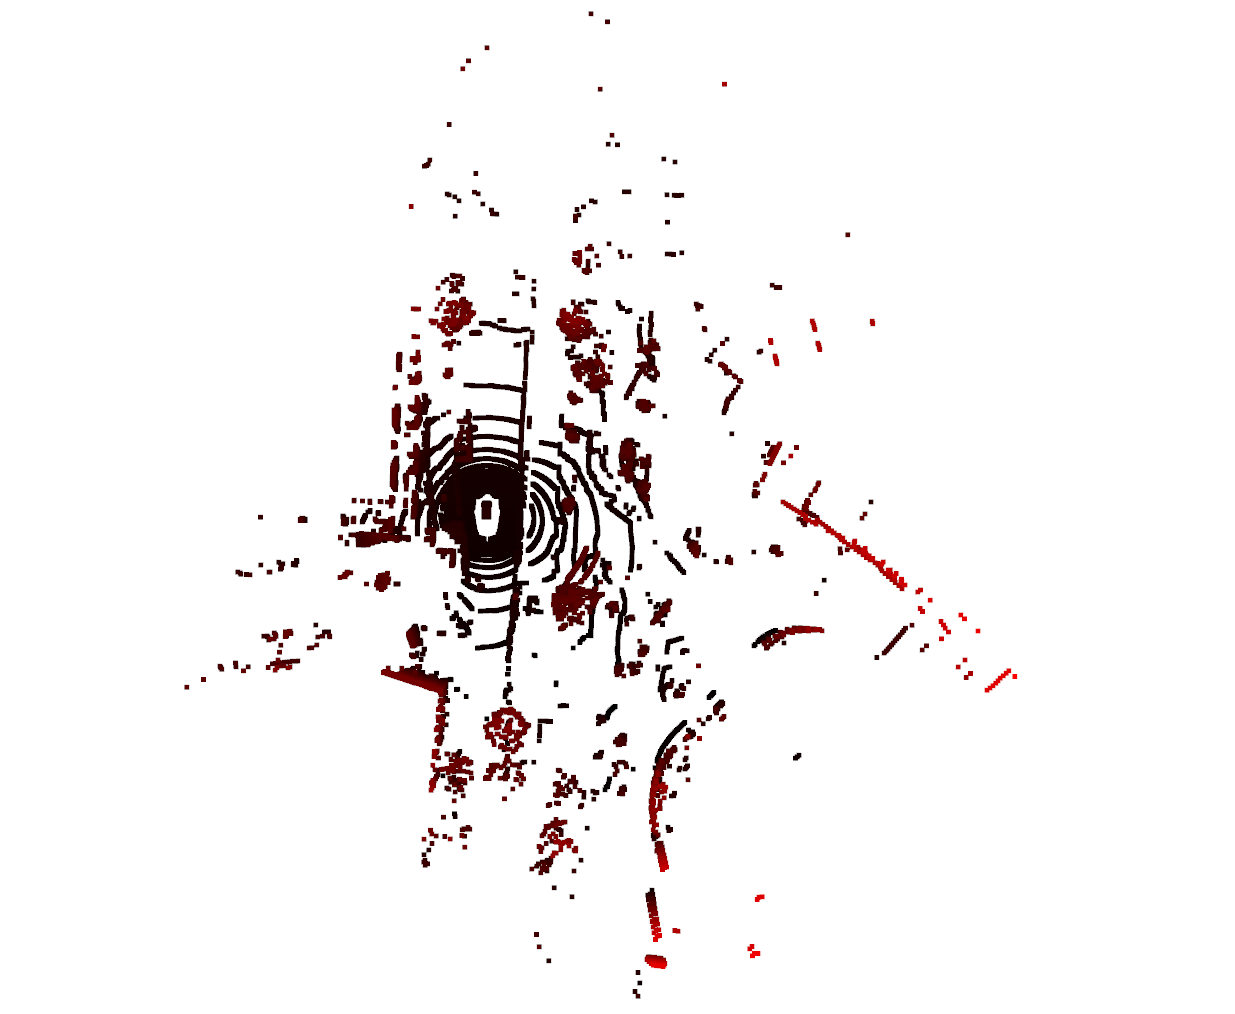

In [23]:
# 5.2 Transform LiDAR --> Ego --> World

def transform_lidar_to_world(nusc, sd_token):
    sd = nusc.get("sample_data", sd_token)

    cs = nusc.get("calibrated_sensor", sd["calibrated_sensor_token"])
    ego = nusc.get("ego_pose", sd["ego_pose_token"])

    T_lidar_ego = pose_to_matrix(cs["translation"], cs["rotation"])
    T_ego_world = pose_to_matrix(ego["translation"], ego["rotation"])

    points = load_lidar_points(nusc, sd_token)
    points_h = np.hstack((points, np.ones((points.shape[0], 1))))

    points_world = (T_ego_world @ T_lidar_ego @ points_h.T).T
    return points_world[:, :3]

In [24]:
# 5.3 Aggregate Over Frames (store per-sweep points)
scene = nusc.scene[0]
sample_token = scene["first_sample_token"]

sweep_world_points = []   # <- list to store each frame's points

while sample_token:
    sample = nusc.get("sample", sample_token)
    lidar_token = sample["data"][CONFIG["lidar_sensor"]]

    pts_world = transform_lidar_to_world(nusc, lidar_token)
    sweep_world_points.append(pts_world)   # store each frame

    sample_token = sample["next"]

# Optional: also make a single aggregated array
global_points = np.vstack(sweep_world_points)


In [25]:
# 5.4 Visualize Aggregated Point Cloud

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(global_points)
o3d.visualization.draw_geometries([pcd])

### Aggregated Point Cloud

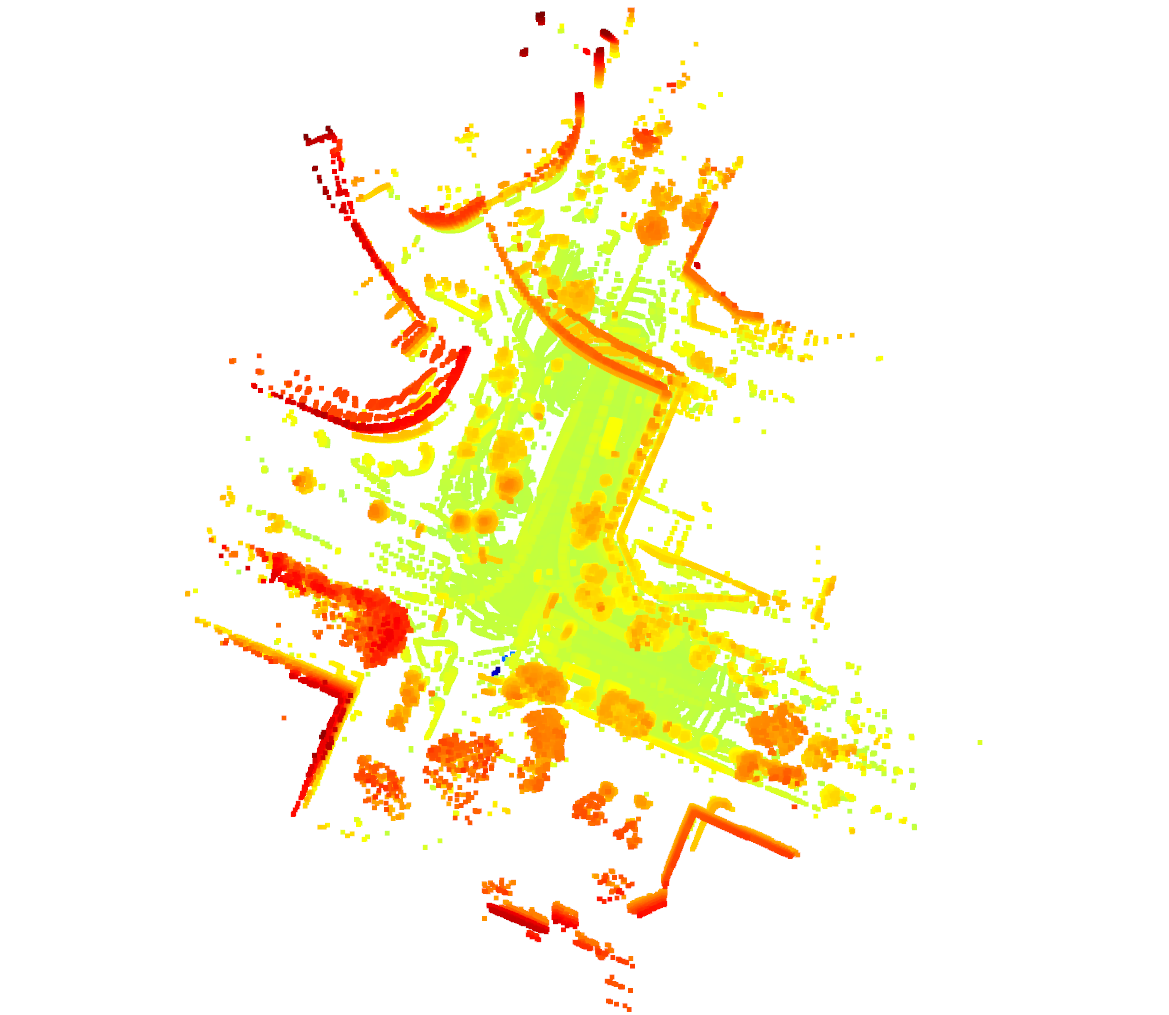

# Task 2: Moving Object Filtering

**Goal:** Remove points corresponding to moving objects (vehicles, pedestrians) without using manual annotations.

**Observation:**  
- Moving objects **appear inconsistently across frames**.  
- Static background points appear **persistently**.

**Approach:**  
1. **Voxel Grid Downsampling** – Reduce point density and unify nearby points.
2. **Temporal Persistence Check** – Keep only points observed in multiple consecutive frames.
3. **Result:** Filtered static map suitable for environment modeling.

In [26]:
import numpy as np
import open3d as o3d
from collections import Counter

# ---------------- Parameters -----------------
VOXEL_SIZE = 0.1              # meters
MIN_VOXEL_HIT_COUNT = 3       # Temporal consistency threshold
DBSCAN_EPS = 0.6              # Spatial clustering radius
DBSCAN_MIN_POINTS = 15        # DBSCAN min neighbors
MIN_CLUSTER_SIZE = 100        # Minimum points to keep a cluster

# ---------------- Helper Functions -----------------
def points_to_voxel_indices(points, origin, voxel_size):
    indices = np.floor((points - origin) / voxel_size).astype(np.int32)
    return indices

# ---------------- Stage 1: Temporal Consistency Filtering -----------------
# sweep_world_points = list of np.array, each frame's LiDAR points in world frame
valid_sweeps = [pts for pts in sweep_world_points if pts.shape[0] > 0]

# Compute global bounding box
global_min = np.min([pts.min(axis=0) for pts in valid_sweeps], axis=0)
voxel_origin = global_min

voxel_occupancy_counter = Counter()

# Count voxel hits across sweeps
for sweep_pts in valid_sweeps:
    voxel_indices = points_to_voxel_indices(sweep_pts, voxel_origin, VOXEL_SIZE)
    unique_voxels = np.unique(voxel_indices, axis=0)
    voxel_tuples = [tuple(v) for v in unique_voxels]
    for v in voxel_tuples:
        voxel_occupancy_counter[v] += 1

# Keep static voxels
kept_voxels = {v for v, count in voxel_occupancy_counter.items() if count >= MIN_VOXEL_HIT_COUNT}

# Filter all points
all_points = np.vstack(valid_sweeps)
all_voxel_indices = points_to_voxel_indices(all_points, voxel_origin, VOXEL_SIZE)
kept_voxel_arr = np.array(list(kept_voxels), dtype=np.int32)

dtype = np.dtype((np.void, kept_voxel_arr.dtype.itemsize * 3))
kept_view = kept_voxel_arr.view(dtype).ravel()
inds_view = np.ascontiguousarray(all_voxel_indices).view(dtype).ravel()
mask_stage1 = np.in1d(inds_view, kept_view)
static_points_stage1 = all_points[mask_stage1]

print(f"Stage-1 static points: {static_points_stage1.shape}")

# ---------------- Stage 2: DBSCAN Spatial Filtering -----------------
pcd_stage1 = o3d.geometry.PointCloud()
pcd_stage1.points = o3d.utility.Vector3dVector(static_points_stage1)

labels = np.array(
    pcd_stage1.cluster_dbscan(
        eps=DBSCAN_EPS,
        min_points=DBSCAN_MIN_POINTS,
        print_progress=True
    )
)

# Keep clusters larger than MIN_CLUSTER_SIZE
cluster_sizes = np.bincount(labels[labels >= 0])
valid_clusters = set(np.where(cluster_sizes >= MIN_CLUSTER_SIZE)[0])
mask_stage2 = np.array([label in valid_clusters for label in labels])
static_points_stage2 = static_points_stage1[mask_stage2]

print(f"Stage-2 filtered static points: {static_points_stage2.shape}")

# Visualize final static map
pcd_final = o3d.geometry.PointCloud()
pcd_final.points = o3d.utility.Vector3dVector(static_points_stage2)
o3d.visualization.draw_geometries([pcd_final])


Stage-1 static points: (298014, 3)
Precompute neighbors.[========================================] 100%
Stage-2 filtered static points: (289598, 3)=======>] 97%


# Task-3: Point Cloud Colorization.

In [27]:
def project_points_to_image(nusc, points_world, cam_sensor_name):
    """
    Project 3D points (Nx3, world) to 2D image coordinates of a camera.
    
    Returns:
        - visible_mask: boolean array of points that fall inside image
        - uv: Nx2 array of pixel coordinates
    """
    import cv2

    # Pick first sample for demonstration
    scene = nusc.scene[0]
    sample_token = scene["first_sample_token"]
    sample = nusc.get("sample", sample_token)
    cam_token = sample["data"][cam_sensor_name]

    # Sample_data + calibration
    sd = nusc.get("sample_data", cam_token)
    cs = nusc.get("calibrated_sensor", sd["calibrated_sensor_token"])
    cam_intrinsic = np.array(cs["camera_intrinsic"])  # 3x3
    ego_pose = nusc.get("ego_pose", sd["ego_pose_token"])

    # Transform world → ego → camera
    T_ego_world = pose_to_matrix(ego_pose["translation"], ego_pose["rotation"])
    T_cam_ego = pose_to_matrix(cs["translation"], cs["rotation"])
    T_world_cam = np.linalg.inv(T_ego_world @ T_cam_ego)

    # Convert points to homogeneous
    points_h = np.hstack([points_world, np.ones((points_world.shape[0], 1))])
    points_cam = (T_world_cam @ points_h.T).T

    # Perspective projection
    uv_h = (cam_intrinsic @ points_cam[:, :3].T).T
    uv = uv_h[:, :2] / uv_h[:, 2:3]

    # Only keep points in front of camera
    mask = points_cam[:, 2] > 0

    return mask, uv


In [28]:
def assign_colors_from_camera(img_path, points_world, nusc, cam_sensor_name):
    img = cv2.imread(img_path)[:, :, ::-1]  # BGR → RGB

    mask, uv = project_points_to_image(nusc, points_world, cam_sensor_name)
    colors = np.zeros_like(points_world)

    h, w, _ = img.shape
    # Only visible points
    visible_uv = uv[mask]
    visible_uv = np.round(visible_uv).astype(int)

    # Clamp to image size
    visible_uv[:, 0] = np.clip(visible_uv[:, 0], 0, w-1)
    visible_uv[:, 1] = np.clip(visible_uv[:, 1], 0, h-1)

    # Sample colors
    colors[mask] = img[visible_uv[:, 1], visible_uv[:, 0]] / 255.0  # normalize 0-1

    return colors


In [29]:
# Assume static_points_stage2 from Task-2
pcd_colored = o3d.geometry.PointCloud()
pcd_colored.points = o3d.utility.Vector3dVector(static_points_stage2)
colors_total = np.zeros_like(static_points_stage2)

for cam in CONFIG["camera_sensors"]:
    sample_token = nusc.scene[0]["first_sample_token"]
    sample = nusc.get("sample", sample_token)
    img_path = os.path.join(CONFIG["dataset_root"], nusc.get("sample_data", sample["data"][cam])["filename"])
    colors_cam = assign_colors_from_camera(img_path, static_points_stage2, nusc, cam)
    colors_total += colors_cam

# Normalize if multiple cameras contributed
colors_total = np.clip(colors_total, 0, 1)
pcd_colored.colors = o3d.utility.Vector3dVector(colors_total)

# Visualize
o3d.visualization.draw_geometries([pcd_colored])

# Save
o3d.io.write_point_cloud("../outputs/colored_pc/final_colored_map.ply", pcd_colored)


True